In [1]:
import torch
from IPython import display
from d2l import torch as d2l

# generate data loader 
batch_size = 256
train_iter , test_iter = d2l.load_data_fashion_mnist(batch_size)

# convert the picture from 3D(col , row , gray_value) to 1D(pixel_index , gray_value)
# the orginal pic size is 28 * 28 , so the pixel_index ranges from 0 - 784(position info lost in this operation)
# there is 10 output categories 
num_inputs = 784
num_outputs = 10

# initialize parameters
W = torch.normal(0 , 0.01 , size=(num_inputs , num_outputs) , requires_grad=True)
b = torch.zeros(num_outputs , requires_grad=True)

# Implementation of SoftMax
$$\hat{y} = \frac{exp(o_j)}{\Sigma _k exp(o_k)} $$

In [2]:
def softmax(x):
    # do exp operation to every element in x
    X_exp = torch.exp(x)
    # sum the exp result of each line
    # partition is a column vector
    partition = X_exp.sum(1 , keepdim=True)
    return X_exp / partition

# verify softmax model
X = torch.normal(0 , 1 , (2 , 5))
X_prob = softmax(X)
X_prob , X_prob.sum(1)    

(tensor([[0.2266, 0.2302, 0.1310, 0.0945, 0.3176],
         [0.0554, 0.5367, 0.0223, 0.1676, 0.2179]]),
 tensor([1.0000, 1.0000]))

In [3]:
# define model
def net(X):
    # reshape input and multi W , then do softmax
    return softmax(torch.matmul(X.reshape((-1 , W.shape[0])) , W) + b)

In [4]:
# loss fuction
def cross_entropy(y_hat , y):
    return -torch.log(y_hat[range(len(y_hat)) , y])

# verify loss
y = torch.tensor([0 , 2])
y_hat = torch.tensor([[0.1 , 0.3 , 0.6] , [0.3 , 0.2 , 0.5]])
cross_entropy(y_hat , y)

tensor([2.3026, 0.6931])

In [5]:
def accuracy(y_hat , y):
    """caculate the numbers of correct prediction"""
    # find the max predict type
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    # convert type and judge 
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat , y) / len(y)

0.5

In [6]:
class Accumulator:
    def __init__(self , n):
        self.data = [0.0] * n
    
    def add(self , *args):
        self.data = [a + float(b) for a , b in zip(self.data , args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self , idx):
        return self.data[idx]

def evaluate_accuracy(net , data_iter):
    """caculate accuracy on a specific dataset"""
    # set the net to eval mode 
    if isinstance(net , torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X , y in data_iter:
        metric.add(accuracy(net(X) , y) , y.numel())
    return metric[0] / metric[1]

evaluate_accuracy(net , test_iter)

0.1099

In [7]:
def train_epoch(net , train_iter , loss , updater):
    if isinstance(net , torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X , y in train_iter:
        y_hat = net(X)
        l = loss(y_hat , y)
        if isinstance(updater , torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(1) * len(y) , accuracy(y_hat , y) , y.size().numel()
            )
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()) , accuracy(y_hat , y) , y.numel())
    return metric[0] / metric[2] , metric[1] / metric[2]

In [8]:
class Animator:
    """show data in animation"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # draw lines incrementally
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # capture parameters using lamda
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # add data point to the chart
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [9]:
lr = 0.1
# SGD
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [10]:
def train(net , train_iter , test_iter , loss , num_epochs , updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


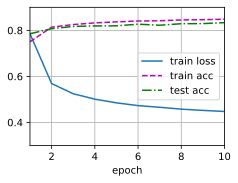

In [11]:
num_epochs = 10
train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

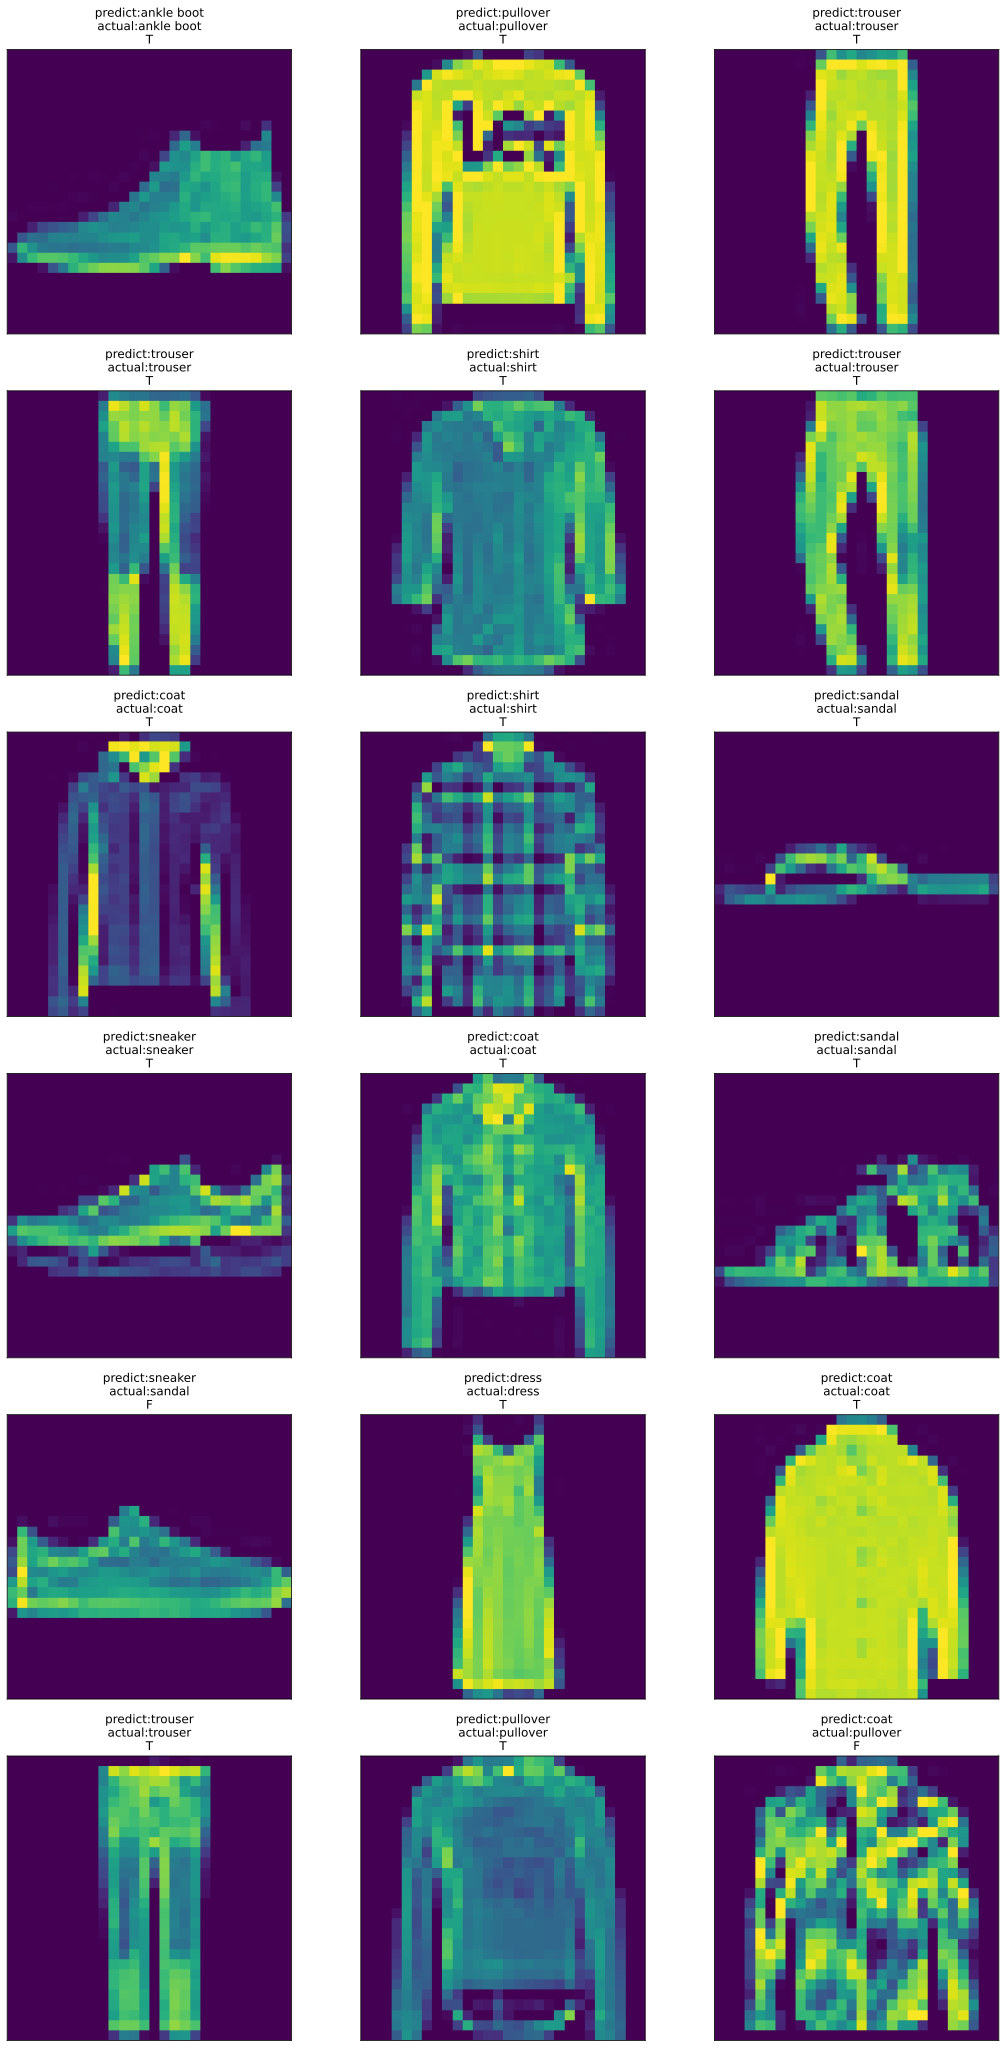

In [12]:
def predict(net, test_iter, n=6):
    """predict labels"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = ['predict:' + true +'\n' + 'actual:' + pred + '\n' + ['F' , 'T'][true == pred] for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), int(n/3) , 3 , titles=titles[0:n] ,scale=6)

predict(net, test_iter , n=20)